# Disney World Wait Times Analysis

Code Louisville Project - Data analysis of Walt Disney World attraction wait times

## Questions
- What is the best time of year to visit Disney World?
- What is the best day of the week to visit Disney World?
- What is the best day of the week to go to each park?

## How did you get the data?

I am a huge Disney fan and wanted to analyze some data from the parks.  I tried contacting Disney themselves but they declined to provide any data.  I also contacted a few well known Disney Podcasters to see if they had any insight into data from the parks.  After emailing several websites, the nice folks at http://touringplans.com provided me with a ton of attraction wait time data. The data was contained in a csv file for each attraction with two columns, the date and the wait time. They provided several years of wait times for the following 9 attractions in Walt Disney World. 

    
| Attraction                 | Park              |
| -------------------------- |------------------ |
| Dinosaur                   | Animal Kingdom    | 
| Expedition Everest         | Animal Kingdom    | 
| Kilimanjaro Safaris        | Animal Kingdom    | 
| Soarin                     | EPCOT             |
| Spaceship Earth            | EPCOT             |
| Rock n Rollercoaster       | Hollywood Studios |
| Toy Story Midway Mainia    | Hollywood Studios |
| Pirates of the Caribbean   | Magic Kingdom     |
| Splash Mountain            | Magic Kingdom     |


### Additional Info
- [Len Testa @lentesta](https://www.twitter.com/lentesta)
- https://www.wired.com/2012/11/len-testa-math-vacation/
- https://www.popsci.com/touring-plan-app-disney-lines

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
import calendar

# Allow Markdown characters in the print statement
def printmd(string):
    display(Markdown(string))

## Wait Times Table

This table will hold the date, wait time and attraction key

In [2]:
conn = sqlite3.connect("wait_times.db")
c = conn.cursor()

# Create the Wait Times Table
sql_create = """
CREATE TABLE IF NOT EXISTS wait_times ( 
    id INTEGER PRIMARY KEY,
    date INTEGER,
    wait_time INTEGER,
    attraction_name TEXT,
    FOREIGN KEY(attraction_name) REFERENCES attractions(name)
);
"""

# remove any data from a previous run
sql_delete = "DELETE FROM wait_times"

try:
    c.execute(sql_create)
    c.execute(sql_delete)
    conn.commit()
finally:
    conn.rollback()
    c.close()
    conn.close()

## Attractions Table

This table will hold reference infromation for each attraction like the full (pretty) name and land

In [3]:
# add foreign key
# also add key to the name of the attraction

conn = sqlite3.connect("wait_times.db")
c = conn.cursor()

# Create the table
attraction_create_sql = """
CREATE TABLE IF NOT EXISTS attractions ( 
    name TEXT PRIMARY KEY,
    full_name TEXT,
    park TEXT
);
"""

attraction_delete_sql = "DELETE FROM attractions"

attraction_insert_sql = """
INSERT INTO attractions 
('name', 'full_name', 'park')
VALUES 
('dinosaur', 'DINOSAUR', 'Animal Kingdom'),
('pirates_of_caribbean', 'Pirates of the Caribbean', 'Magic Kingdom'),
('expedition_everest', 'Expedition Everest', 'Animal Kingdom'),
('kilimanjaro_safaris', 'Kilimanjaro Safaris', 'Animal Kingdom'),
('rock_n_rollercoaster', 'Rock n Roller Coaster', 'Hollywood Studios'),
('soarin', 'Soarin', 'EPCOT'),
('spaceship_earth', 'Spaceship Earth', 'EPCOT'),
('splash_mountain', 'Splash Mountain', 'Magic Kingdom'),
('toy_story_mania', 'Toy Story Mania!', 'Hollywood Studios')
"""

try:
    c.execute(attraction_create_sql)
    c.execute(attraction_delete_sql)
    c.execute(attraction_insert_sql)
    conn.commit()
finally:
    conn.rollback()
    c.close()
    conn.close()

In [4]:
# Sqlite db file will continute to grow in size after any deletes or drops
# This will optimize the database file and reduce its size
# You can also just remove the db file and recreate.
# http://www.sqlitetutorial.net/sqlite-vacuum/
conn = sqlite3.connect("wait_times.db")
conn.execute("VACUUM")

## Transforming the data

The data arrived in separate files for each attraction with three columns of info: Date, Datetime, Wait Time.  I wanted the data to be in a single sql lite table for easier processing and analysis.  The following script will loop over each csv file and insert date time, wait time, attraction name into a "wait_times" table in sqlite.

#### Steps
- Read each csv file into a pandas data frame
- Change the names of the columns in the csv file from datetime, SPOSTMIN to date, wait_time
- **NOTE**: Some data is showing -999 for a wait time. This is an issue with the data collection methods. Since there can be no negative wait times, I have removed this information from the sqlite table.  The data can still be found in the original csv files. 
- Add an "attraction" name column
- Append the data to the wait_times sqlite database

In [5]:
conn = sqlite3.connect("wait_times.db")
c = conn.cursor()
 
# List of attraction data
attractions = ["dinosaur", "expedition_everest", "kilimanjaro_safaris", "pirates_of_caribbean", "rock_n_rollercoaster", "soarin", "spaceship_earth", "splash_mountain", "toy_story_mania"]

printmd("### Loading Attraction Data...")

# load into sqlite table
for attraction in attractions:
    filepath = 'csv/{}.csv'.format(attraction)
    
    # read csv file
    df = pd.read_csv(filepath, parse_dates=['datetime'], usecols=['datetime', 'SPOSTMIN'])
    
    # change the columns names from the csv file to something more appropriate
    df.columns = ['date', 'wait_time']
    
    # the data has some issues with negative wait times.  This removes these data points
    df.drop(df[df.wait_time < 0].index, inplace=True)
    
    # add a new column 'attraction' with the attraction name
    df['attraction_name'] = attraction
    
    # append the data to the 'wait_times' table in the 'wait_times.db'
    df.to_sql("wait_times", sqlite3.connect("wait_times.db"), if_exists = "append", index=False)
    
    # output the attraction
    print(f'- {attraction} ({attraction}.csv)')



### Loading Attraction Data...

- dinosaur (dinosaur.csv)
- expedition_everest (expedition_everest.csv)
- kilimanjaro_safaris (kilimanjaro_safaris.csv)
- pirates_of_caribbean (pirates_of_caribbean.csv)
- rock_n_rollercoaster (rock_n_rollercoaster.csv)
- soarin (soarin.csv)
- spaceship_earth (spaceship_earth.csv)
- splash_mountain (splash_mountain.csv)
- toy_story_mania (toy_story_mania.csv)


## Analysis of the data itself

A data analyst should not only be concerned with querying the data to answer questions, but should also provide information about the data itself.  How big is the data? How wide is the data? How many years does the data cover?  What is the smallest, largest, average of the data.  These types of results will provide context for anyone reviewing the data. 

Analysis includes
- Total number of records
- Oldest and Newest records
- Records by attraction
- Records by minute wait time
- Graph of Records by minute wait time


### Total Wait Time Records: 1,882,193


### Records Date Span
- Earliest Record: 2012-01-01 08:28:00
- Latest Record: 2018-06-07 23:00:00


### Records by Year
| Year | Count   |
|------|---------|
| 2012 | 105,692 |
| 2013 | 290,746 |
| 2014 | 303,414 |
| 2015 | 369,495 |
| 2016 | 302,906 |
| 2017 | 352,232 |
| 2018 | 157,708 |


### Records by Attraction
| Park | Name    | Count |
|------|---------|-------|
| Animal Kingdom | DINOSAUR | 176,832
| Animal Kingdom | Expedition Everest | 195,642
| Animal Kingdom | Kilimanjaro Safaris | 189,228
| Magic Kingdom | Pirates of the Caribbean | 224,919
| Hollywood Studios | Rock n Roller Coaster | 218,670
| EPCOT | Soarin | 223,424
| EPCOT | Spaceship Earth | 221,935
| Magic Kingdom | Splash Mountain | 208,294
| Hollywood Studios | Toy Story Mania! | 223,249


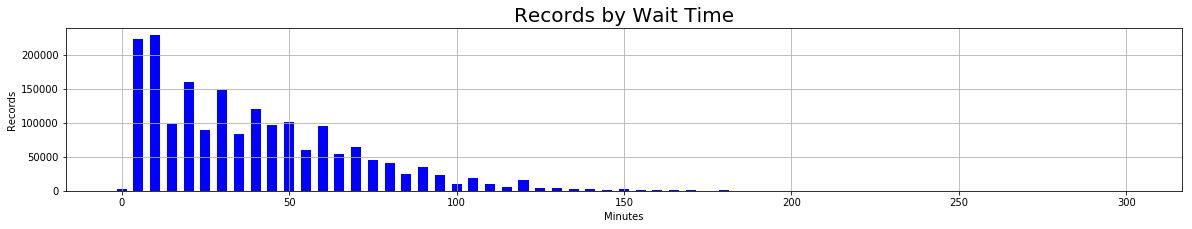

In [6]:
conn = sqlite3.connect("wait_times.db")

# This will provide both index-based and case-insensitive name-based access to columns
conn.row_factory = sqlite3.Row
c = conn.cursor()

try:
    # SQL statements
    total_count_sql = """
    SELECT count(*) as total_count 
    FROM wait_times
    """

    date_span_sql = """
    SELECT MIN(DATE) as min_date, MAX(date) as max_date 
    FROM wait_times
    """
    
    attraction_count_sql = """
    SELECT full_name, park, count(*) as attraction_count
    FROM wait_times w
        INNER JOIN attractions a ON w.attraction_name = a.name
    GROUP BY attraction_name, park
    ORDER BY attraction_name
    """
    
    year_count_sql = """
    SELECT strftime('%Y', date) as year, count(*) as year_count
    FROM wait_times
    GROUP BY 1
    ORDER BY 1
    """
    
    minute_counts_sql = """
    SELECT wait_time, count(*) as wait_time_count
    FROM wait_times
    GROUP BY wait_time
    ORDER BY wait_time
    """
    
    # run the queries
    total_count = c.execute(total_count_sql).fetchone()[0]
    date_span = c.execute(date_span_sql).fetchone()
    year_count = c.execute(year_count_sql).fetchall()
    attraction_counts = c.execute(attraction_count_sql).fetchall()
    minute_counts = c.execute(minute_counts_sql).fetchall()
    
    #
    # TOTAL RECORDS
    #
    
    # output the results
    printmd(f"### Total Wait Time Records: {total_count:,}")
    
    #
    # RECORDS DATE SPAN
    #
    
    # This is an example of a named row (see row_factory sqlite3.Row above)
    printmd(f"""
### Records Date Span
- Earliest Record: {date_span['min_date']}
- Latest Record: {date_span['max_date']}
""")
    
    
    #
    # RECORDS BY YEAR
    #
    print_records_by_year = """### Records by Year
| Year | Count   |
|------|---------|
"""
    for row in year_count:
        print_records_by_year += f"| {row['year']} | {row['year_count']:,} |\n"
        #print("{} - {:,}".format(*row))
    
    printmd(print_records_by_year)

    
    #
    # RECORDS BY ATTRACTION
    #
    print_records_by_attraction = """### Records by Attraction
| Park | Name    | Count |
|------|---------|-------|
"""
    for row in attraction_counts:
        print_records_by_attraction += f"| {row['park']} | {row['full_name']} | {row['attraction_count']:,}\n"
        
    printmd(print_records_by_attraction)   
    
    minutes_list = []
    minute_records = []
    for row in minute_counts:
        minutes_list.append(row[0])
        minute_records.append(row[1])
        #print("Minute {} - {:,}".format(*row), end=' | ')
        #if row[0] % 3 == 0:
            #print("\n")

    # bar chart
    plt.figure(figsize=(20, 3))
    plt.bar(minutes_list, minute_records, color="blue", width=3)
    plt.xlabel('Minutes')
    plt.ylabel('Records')
    plt.title('Records by Wait Time', fontsize=20)
    plt.grid(True)
    plt.show()

    conn.commit()
finally:
    conn.rollback()
    c.close()
    conn.close()

### What time of the year is best to visit Disney World?

In [ ]:
# load data into a pandas dataframe, manipulate, visualize, etc

In [9]:
data = conn.execute('select * from wait_times limit 10')
print(data)

In [5]:
df.shape

(223249, 3)

In [19]:
con = sqlite3.connect("wait_times.db")
wait_times_df = pd.read_sql_query("SELECT date, wait_time FROM wait_times", con)
wait_times_df.head()

,date,wait_time
0,2012-01-01 08:28:00,5
1,2012-01-01 08:48:00,10
2,2012-01-01 09:16:00,10
3,2012-01-01 11:07:00,10
4,2012-01-01 11:56:00,5


In [20]:
con = sqlite3.connect("wait_times.db")
wait_times_df = pd.read_sql_query("SELECT count(*) FROM wait_times", con)
wait_times_df

,count(*)
0,1882193


In [11]:
con = sqlite3.connect("wait_times.db")

sql = """
SELECT full_name, printf("%.0f", avg(wait_time)) AS avg_wait_time
FROM wait_times w
    INNER JOIN attractions a ON w.attraction = a.name
WHERE date between '2013-01-01' and '2013-12-31'
GROUP BY attraction
ORDER BY avg_wait_time
"""

wait_times_df = pd.read_sql_query(sql, con)
wait_times_df

,full_name,avg_wait_time
0,Spaceship Earth,10
1,Pirates of the Caribbean,14
2,Dinosaur,18
3,Kilimanjaro Safaris,26
4,Expedition Everest,28
5,Splash Mountain,34
6,Rock n Roller Coaster Starring Aerosmith,54
7,Soarin,62
8,Toy Story Midway Mania,75


In [61]:
conn = sqlite3.connect("wait_times.db")
c = conn.cursor()

sql = """
SELECT attraction_name, avg(wait_time) as avg_wait_time
FROM wait_times
WHERE date between '2017-01-01' and '2017-12-31'
GROUP BY attraction_name
ORDER BY avg_wait_time
"""

wait_times_df = pd.read_sql_query(sql, conn)
wait_times_df

,attraction_name,avg_wait_time
0,spaceship_earth,21.077705
1,dinosaur,26.787297
2,pirates_of_caribbean,30.501258
3,expedition_everest,35.098597
4,kilimanjaro_safaris,37.900485
5,soarin,46.884443
6,splash_mountain,50.577942
7,toy_story_mania,52.017794
8,rock_n_rollercoaster,65.735670


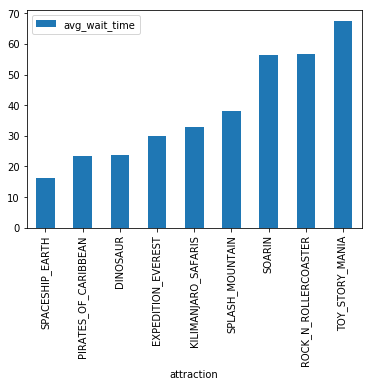

In [22]:
wait_times_df.plot(x="attraction", kind="bar")



In [9]:
conn = sqlite3.connect("wait_times.db")

# SQL average
sql = """
SELECT strftime('%Y', date) as year, avg(wait_time) as avg_wait_time
FROM wait_times 
WHERE attraction_name = "toy_story_mania"
GROUP BY year 
ORDER BY year
"""

average_by_year_df = pd.read_sql_query(sql, conn)
average_by_year_df

,year,avg_wait_time
0,2012,67.621119
1,2013,75.214372
2,2014,69.569405
3,2015,73.587091
4,2016,59.620290
5,2017,52.122485
6,2018,84.922451


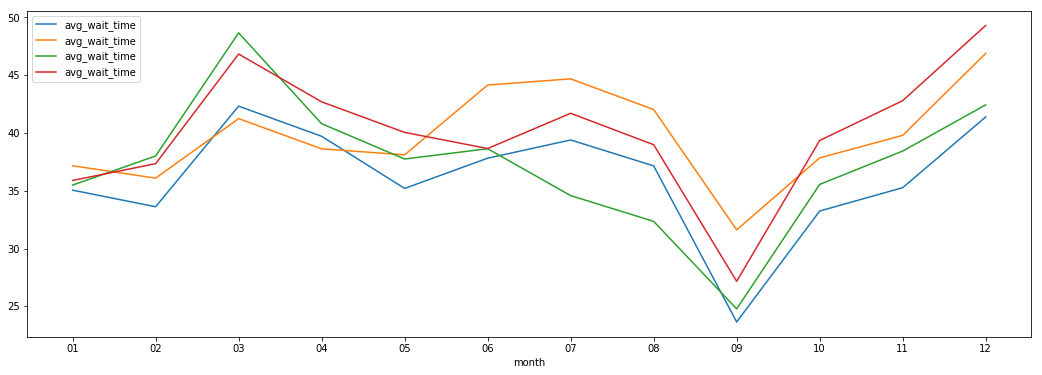

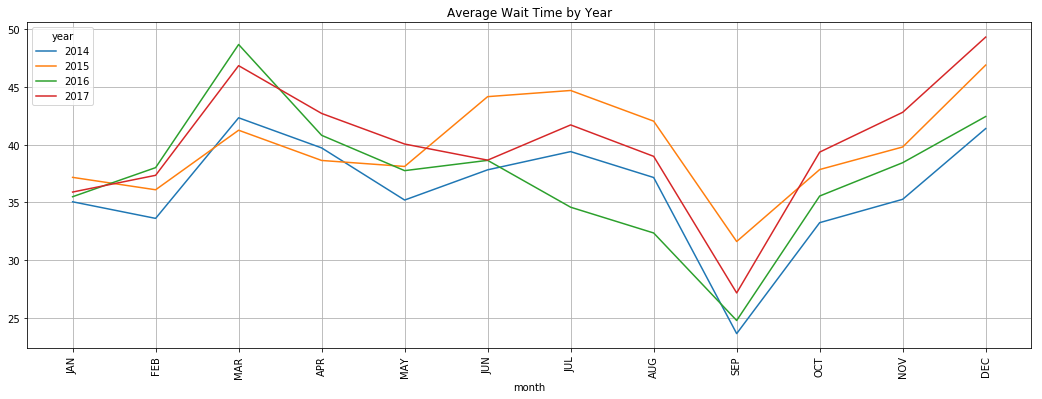

In [46]:
conn = sqlite3.connect("wait_times.db")
c = conn.cursor()

# SQL average
sql = """
SELECT strftime('%Y', date) as year,
       strftime('%m', date) as month, 
       avg(wait_time) as avg_wait_time
FROM wait_times 
WHERE wait_time > 0
AND date between '2014-01-01' and '2017-12-31'
GROUP BY year, month 
ORDER BY year, month
"""

average_by_year_df = pd.read_sql_query(sql, conn)

#average_by_year_df.groupby('year').plot(x='month', y='avg_wait_time')


fig, ax = plt.subplots(figsize=(18,6))

ax.set_xticks(range(len(average_by_year_df)))
ax.set_xticklabels(["JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"], rotation=90);
average_by_year_df.groupby('year').plot(x='month', y='avg_wait_time', ax=ax, legend=True)


average_by_year_df = average_by_year_df.pivot(index='month', columns='year', values='avg_wait_time')

ax = average_by_year_df.plot(figsize=(18,6))
ax.set_xticks(range(len(average_by_year_df)))
ax.set_xticklabels(["JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"], rotation=90);
ax.set_title('Average Wait Time by Year')
ax.grid(True)

# x = []
# y = []
# for index, row in average_by_year_df.groupby(['year']):
#     x.append(int(row['month']))
#     y.append(row['avg_wait_time'])
#     #print(row['month'], row['avg_wait_time'])
#     plt.plot(x, y, color="red")

# plt.show()

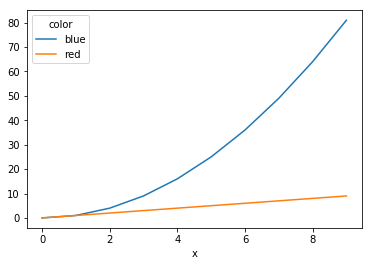

In [102]:
df = pd.DataFrame([
    ['red', 0, 0],
    ['red', 1, 1],
    ['red', 2, 2],
    ['red', 3, 3],
    ['red', 4, 4],
    ['red', 5, 5],
    ['red', 6, 6],
    ['red', 7, 7],
    ['red', 8, 8],
    ['red', 9, 9],
    ['blue', 0, 0],
    ['blue', 1, 1],
    ['blue', 2, 4],
    ['blue', 3, 9],
    ['blue', 4, 16],
    ['blue', 5, 25],
    ['blue', 6, 36],
    ['blue', 7, 49],
    ['blue', 8, 64],
    ['blue', 9, 81],
], columns=['color', 'x', 'y'])

df = df.pivot(index='x', columns='color', values='y')

df.plot()

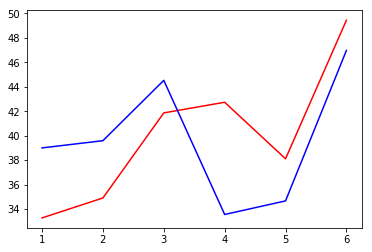

In [71]:


x =  [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
y1 = [33.28, 34.91, 41.86, 42.73, 38.11, 49.43]
y2 = [39.00, 39.59, 44.52, 33.56, 34.67, 46.96]

#plt.plot([1, 2, 3, 4], [1, 4, 9, 16], color="red", linestyle="dashdot", label="dashdot")
#plt.plot([1, 2, 3, 4, 5, 6], [33, 34, 41, 42, 38, 49,43])
plt.plot(x, y1, color="red")
plt.plot(x, y2, color="blue")
plt.show()

In [ ]:
dinosaur_df.describe()

In [ ]:
dinosaur_df['year'] = pd.DatetimeIndex(dinosaur_df['date']).year

In [ ]:
dinosaur_df.columns

In [ ]:
dinosaur_df['date'] = pd.to_datetime(dinosaur_df['date'])

In [ ]:
dinosaur_df.groupby(dinosaur_df.date.dt.year)
dinosaur_df

In [25]:
# pandas mean
mean_df = dinosaur_df.groupby('year').mean()
mean_df

NameError: name 'dinosaur_df' is not defined